In [1]:
import math
from math import comb
import matplotlib.pyplot as plt   # we use matplotlib for plotting
import numpy as np                # we use numpy for random number generation 
import pandas as pd               # we use pandas for summary stats
from scipy.optimize import minimize
import pdb
from numpy import ndarray

import joblib

In [19]:
# Read the MSC dataset
SLICE = 1000
df = pd.read_csv('data/HC.SitesDiffs.txt', delimiter='\t')
# df = df[:SLICE]
print("original data consisting of sequence alignments from the human and the chimpanzee at L=1000 loci ")
# Display the DataFrame
df.head()

original data consisting of sequence alignments from the human and the chimpanzee at L=1000 loci 


,ni,xi
0,120,2
1,387,6
2,595,9
3,521,7
4,560,9


In [21]:
ni, xi = df.loc[1]
ni
# df = df.loc[]
len(df)

14663

In [4]:
type(df.iloc[:, 0].values)

numpy.ndarray

In [22]:

def acf(x, maxlag=10):
  laglist = []
  maxlag = min(maxlag,len(x)-1)

  mean  = sum(x)/len(x)                                    # equiv. to: np.mean(x)
  stdev = math.sqrt(sum([(i-mean)**2 for i in x])/len(x))  # equiv. to: np.std(x)
  y = [(i-mean)/stdev for i in x]                          # equiv. to: (np.array(x)-mean)/stdev

  for lag in range(2,maxlag):

    # now calculate rho as the sum of products of y[i] and y[i+lag]
    rho = sum(y[i]*y[i+lag] for i in range(len(y)-lag)) / (len(y)-lag)

    if rho < 0:
      break 

    laglist.append(rho)

  return laglist

In [24]:
SLICE = 1000
df = pd.read_csv('data/HC.SitesDiffs.txt', delimiter='\t')
# df = df[:SLICE]
def logpriorlikelihood(tau, theta, coalescent_times, df = df, tau_prior = 5e-3, theta_prior = 1e-3):
    '''
    main function to give feedback to random walk (vectorized implementation to speed up computation)
    Args:
      df: pd.DataFrame - dataset containing the number of differences (xi) at ni sites at locus i
      tau: float - Speciation time parameter  
      theta: float - Population size parameter
      coalescent_times: np.array - coalescent time of locus i, for L=1000 loci 
      tau_prior: float - prior parameter of tau, by default it's 0.005, 
      theta_prior: float - prior parameter of theta, by default it's  1e-3
      
    Returns:
      unnormalized posterior given input parameters
    '''
    # Assuming df contains 1000 rows with two columns n and x
    n: ndarray = df.iloc[:, 0].values
    x: ndarray = df.iloc[:, 1].values

    # Calculate p using vectorized operations
    # t: ndarray = coalescent_times.reshape(-1, 1) # perplexity's Pro's answer
    p: ndarray = 3/4 - 3/4 * np.exp(-8/3 * (tau + coalescent_times))

    # # Sum up the values along the first axis to get the total sum
    sum_coalescent_times: float = np.sum(np.log((2/(theta))) - 2/theta * coalescent_times + \
                                         x * np.log(p) + (n - x) * np.log((1 - p)))

    unnormalized_posterior: float = -1/tau_prior * tau - 1/theta_prior * theta + sum_coalescent_times
    
    return unnormalized_posterior

def lnratio_tj_vectorized(tau, theta, proposed_tjs, tjs, df = df):
    '''
    Vectorized helper function during MCMC to simplify log ratio computation for changing coalescent times.
    Args:
      tau: Current value of tau.
      theta: Current value of theta.
      proposed_tjs: Array of proposed coalescent times.
      tjs: Array of current coalescent times.
      df: DataFrame containing the number of differences (xi) at ni sites at locus i.
    Returns:
      Array of log ratios for each proposed coalescent time change.
    '''
    
    p_stars = 3/4 - 3/4 * np.exp(-8/3 * (tau + proposed_tjs))
    ps = 3/4 - 3/4 * np.exp(-8/3 * (tau + tjs))
    
    njs, xjs = df.iloc[:, 0].values, df.iloc[:, 1].values

    log_ratios = -2/theta * (proposed_tjs - tjs) + xjs * np.log((p_stars) / (ps)) + \
                 (njs - xjs) * np.log((1 - p_stars) / (1 - ps))
    
    return log_ratios
  

### INIT PARAMETERS
w_tau = 0.001
w_theta =  0.001
w_t = 0.019

tau = 0.01
theta = 0.001
coalescent_times = np.array([0.001 for _ in range(df.shape[0])]) # 1000 coalescent times

init_windows = (w_tau, w_theta, w_t)
init_params = (tau, theta, coalescent_times)

# long run
BURNIN = 5000
SAMPLES = 20000
###
def mcmc(steps = SAMPLES, init_windows = init_windows, init_params = init_params):  
  '''
  window sizes (w_tau = 0.01, w_theta = 0.002, w_t = 0.002)
  initial parameters tau = 0.01, theta = 0.001, and ti = 0.001, for i = 1, …, L
  '''

  w_tau, w_theta, w_t = init_windows

  tau, theta, coalescent_times = init_params

  sample_tau = []
  sample_theta = []
  sample_coalescent_times = np.zeros(shape=(len(coalescent_times), steps))

  accepted_tau = accepted_theta = 0
  accepted_times = np.zeros_like(coalescent_times) # log acceptance rate per each coalescent time of a locus

  lnp = logpriorlikelihood(tau = tau, theta = theta, coalescent_times = coalescent_times)

  for mcmc_iteration in range(steps):
    
    ### CHANGE TAU with theta and coalescent times fixed
    proposed_tau = tau + (np.random.uniform(0, 1) - 0.5) * w_tau
    if proposed_tau < 0:
      proposed_tau = -proposed_tau
    
    # calculate unnormalized posterior for proposed theta, and posterior ratio
    lnpnew = logpriorlikelihood(tau = proposed_tau, theta = theta, coalescent_times=coalescent_times)
    logratio = lnpnew - lnp  # reuse lnp instead of computing it again

    if logratio >= 0 or np.random.uniform() < math.exp(logratio):
      # we accept the proposal
      tau = proposed_tau
      lnp = lnpnew
      accepted_tau += 1

    # we log a sample regardless whether we accepted the proposal or not
    sample_tau.append(tau)

    ### CHANGE THETA with tau and coalescent times fixed
    # set a different window size to increase acceptance rate of w2 to 43%
    proposed_theta = np.random.uniform(theta - w_theta/2, theta + w_theta/2)
    
    if proposed_theta < 0:
      proposed_theta = -proposed_theta
    
    # calculate unnormalized posterior for proposed theta, and posterior ratio
    lnpnew = logpriorlikelihood(tau = tau, theta = proposed_theta, coalescent_times = coalescent_times)
    logratio = lnpnew - lnp # reuse lnp instead of computing it again

    if logratio >= 0 or np.random.uniform() < math.exp(logratio):
      # we accept the proposal
      theta = proposed_theta
      lnp = lnpnew
      accepted_theta += 1
    
    sample_theta.append(theta)

    # CHANGE COALESCENT times with tau and theta fixed
    proposed_coalescent_times = coalescent_times + (np.random.uniform(0, 1, size=len(coalescent_times)) - 0.5) * w_t
    proposed_coalescent_times = np.where(proposed_coalescent_times < 0, -proposed_coalescent_times, proposed_coalescent_times)
    # Vectorized implementation treats coalescent times as independent
    logratios = lnratio_tj_vectorized(tau = tau, theta = theta, proposed_tjs = proposed_coalescent_times,\
                                      tjs = coalescent_times)
    
    # Calculate acceptance probabilities and determine which proposals to accept
    acceptance_probs = np.exp(logratios)
    accepts = (logratios >= 0) | (np.random.uniform(size=len(coalescent_times)) < acceptance_probs)
    
    # Update accepted coalescent times and log posterior
    accepted_indices = np.where(accepts)[0]
    for idx in accepted_indices:
        coalescent_times[idx] = proposed_coalescent_times[idx]
        lnp += logratios[idx]
        accepted_times[idx] += 1
    
    # Log the samples for this iteration
    sample_coalescent_times[:, mcmc_iteration] = coalescent_times

  # return the sample and the number of accepted proposals
  return sample_tau, sample_theta, sample_coalescent_times, accepted_tau, accepted_theta, accepted_times


In [25]:
# Calling the MCMC
sample = SAMPLES
sample_tau, sample_theta, sample_coalescent_times, \
    accepted_tau, accepted_theta, accepted_times \
        = mcmc(steps=sample)


In [26]:
coalescent_times_acceptance_rates = [accepted_time/sample for accepted_time in accepted_times]
print(np.mean(coalescent_times_acceptance_rates), np.std(coalescent_times_acceptance_rates))

0.3728902373320603 0.1312663535886578


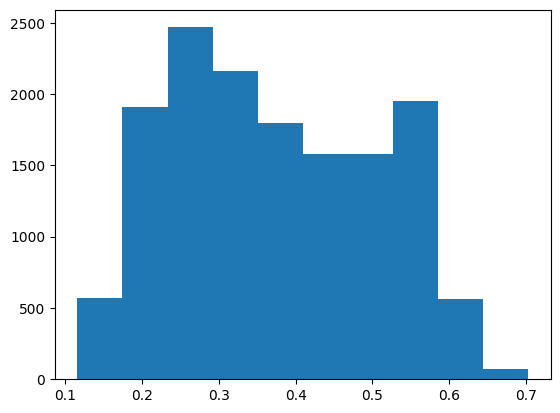

In [27]:
plt.hist([accepted_time/sample for accepted_time in accepted_times])
plt.show()

In [28]:
sample_tau_burned = sample_tau[BURNIN:]
sample_theta_burned = sample_theta[BURNIN:]


In [29]:
# show summary statistics for the runs discarding the first BURNIN samples
print("Summary for tau samples")
print(pd.DataFrame(sample_tau_burned).describe()[0])
eff = 1/(1+2*sum(acf(sample_tau_burned)))
print("Acceptance: {}".format(accepted_tau/SAMPLES))
print("Efficiency: {}\n".format(eff))

# show summary statistics for the runs discarding the first BURNIN samples
print("Summary for theta samples")
print(pd.DataFrame(sample_theta_burned).describe()[0])
eff = 1/(1+2*sum(acf(sample_theta_burned)))
print("Acceptance: {}".format(accepted_theta/SAMPLES))
print("Efficiency: {}\n".format(eff))


Summary for tau samples
count    15000.000000
mean         0.004174
std          0.000042
min          0.004060
25%          0.004147
50%          0.004175
75%          0.004202
max          0.004298
Name: 0, dtype: float64
Acceptance: 0.0683
Efficiency: 0.06477373130528906

Summary for theta samples
count    15000.000000
mean         0.004370
std          0.000088
min          0.004065
25%          0.004311
50%          0.004365
75%          0.004427
max          0.004658
Name: 0, dtype: float64
Acceptance: 0.11445
Efficiency: 0.0649975521615389



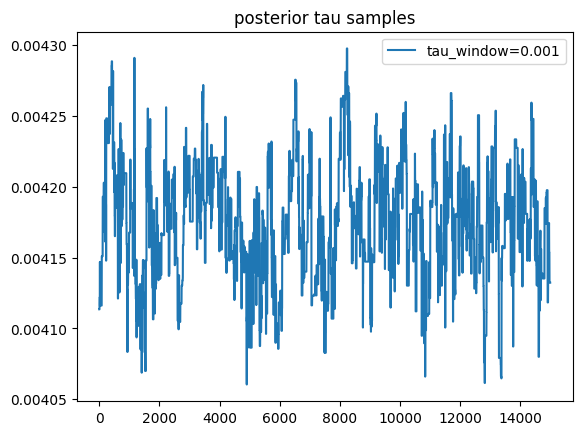

In [30]:
# plot the three runs
plt.plot(list(range(len(sample_tau_burned))),sample_tau_burned,label=f"tau_window={w_tau}")
plt.title('posterior tau samples')
plt.legend()
plt.show()

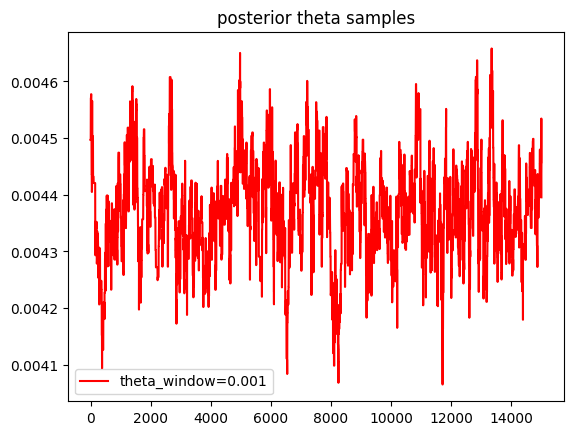

In [31]:
# plot the three runs
plt.plot(list(range(len(sample_theta_burned))),sample_theta_burned,label=f"theta_window={w_theta}", color='r')
plt.title('posterior theta samples')
plt.legend()
plt.show()

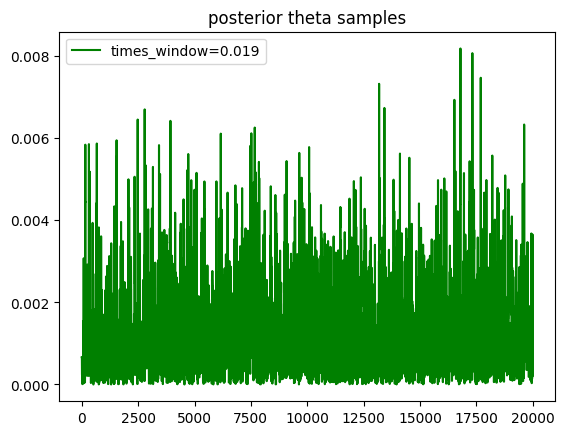

In [32]:
time_idx = 420
# plot the three runs
plt.plot(list(range(len(sample_coalescent_times[time_idx, :]))),sample_coalescent_times[time_idx, :],label=f"times_window={w_t}", color='g')
plt.title('posterior theta samples')
plt.legend()
plt.show()

# Credibility intervals

In [33]:
print(f'For tau, we obtain a posterior mean of {np.mean(sample_tau_burned):.6f} \nwith 2.5% and 97.5% cred. interval [{np.quantile(sample_tau_burned, 0.025):.6f}, {np.quantile(sample_tau_burned, 0.975):.6f}]')
print(f'For theta, we obtain a posterior mean of {np.mean(sample_theta_burned):.6f} \nwith 2.5% and 97.5% cred. interval [{np.quantile(sample_theta_burned, 0.025):.6f}, {np.quantile(sample_theta_burned, 0.975):.6f}]')

For tau, we obtain a posterior mean of 0.004174 
with 2.5% and 97.5% cred. interval [0.004090, 0.004259]
For theta, we obtain a posterior mean of 0.004370 
with 2.5% and 97.5% cred. interval [0.004203, 0.004551]


# Experiments varying window size

In [55]:
w_tau = 0.00053
w_theta =  0.0009 
w_t = 0.019
tau_windows = np.logspace(np.log10(w_tau)-2, np.log10(w_tau)+2, 3)
theta_windows = np.logspace(np.log10(w_theta)-2, np.log10(w_theta)+2, 3)


3

tau window: 0.000, theta window: 0.000
Summary for tau samples
             0
mean  0.007019
std   0.000694
Acceptance: 0.89395
Efficiency: 0.05886919070887922

Summary for theta samples
             0
mean  0.000094
std   0.000022
Acceptance: 0.73175
Efficiency: 0.05951406724303351



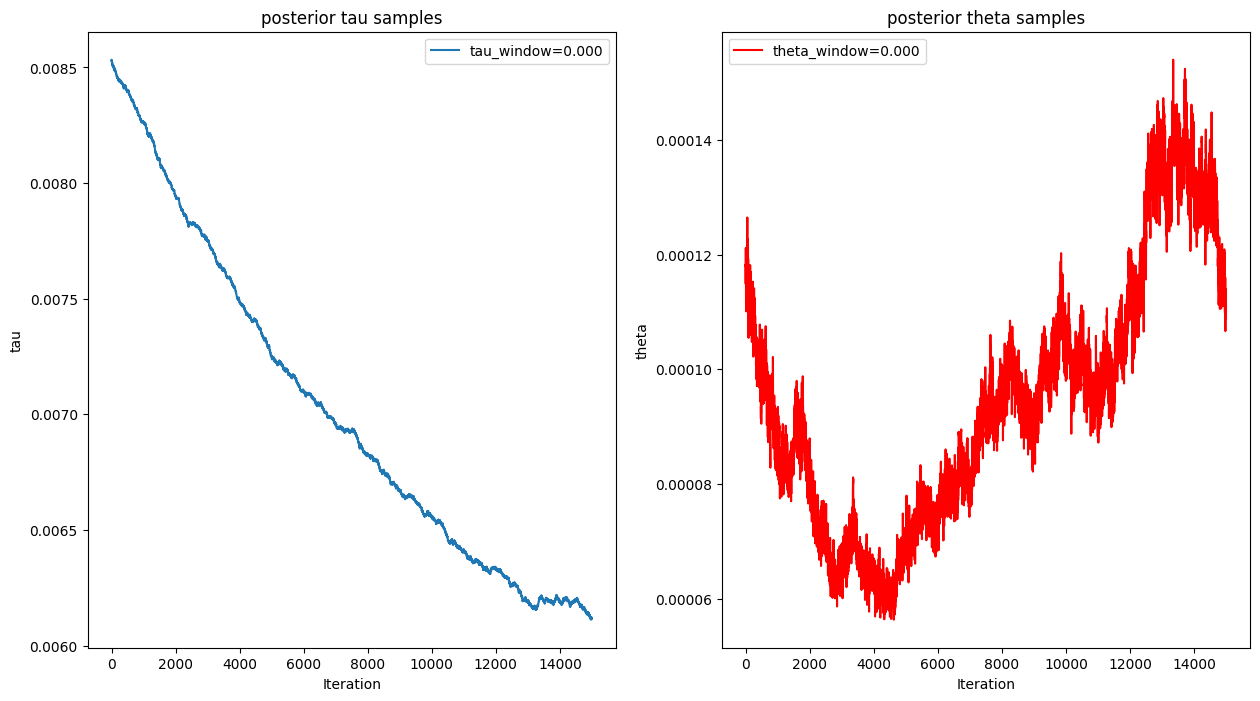

For tau, we obtain a posterior mean of 0.007019 
with 2.5% and 97.5% cred. interval [0.006164, 0.008422]
For theta, we obtain a posterior mean of 0.000094 
with 2.5% and 97.5% cred. interval [0.000061, 0.000140]


tau window: 0.000, theta window: 0.001
Summary for tau samples
             0
mean  0.007053
std   0.000664
Acceptance: 0.8953
Efficiency: 0.05887176666704269

Summary for theta samples
             0
mean  0.000074
std   0.000014
Acceptance: 0.021
Efficiency: 0.059022920171310604



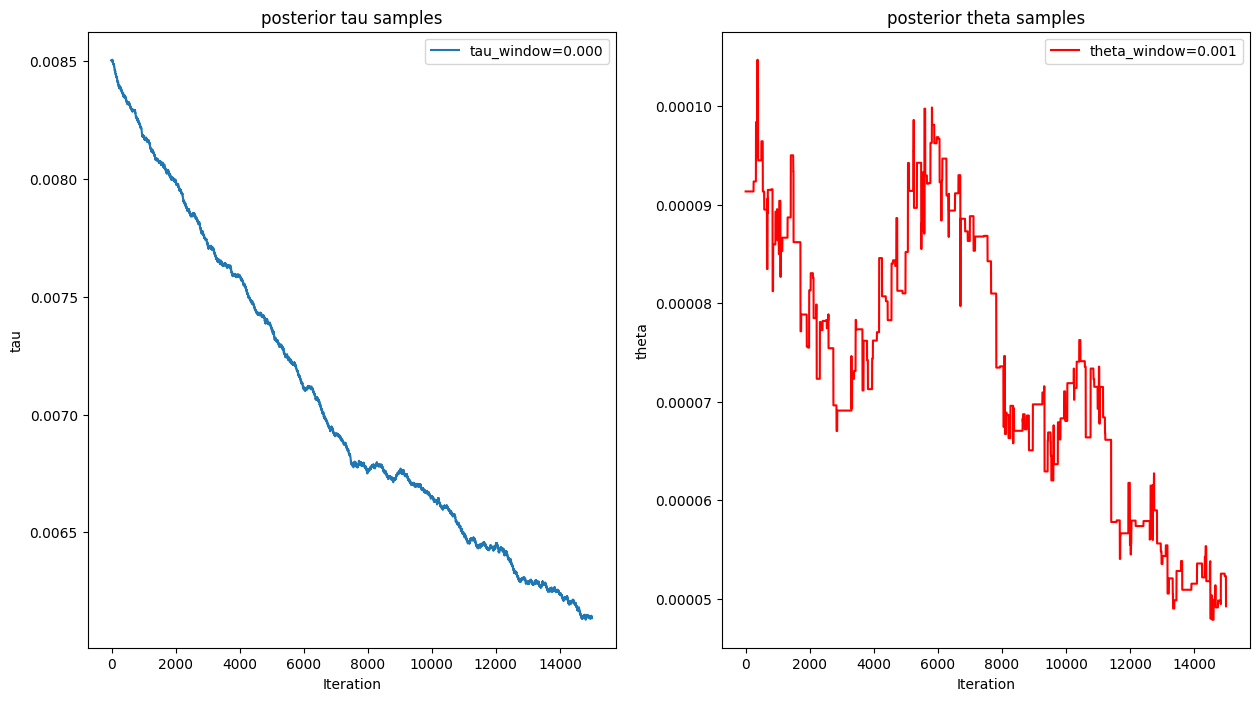

For tau, we obtain a posterior mean of 0.007053 
with 2.5% and 97.5% cred. interval [0.006159, 0.008356]
For theta, we obtain a posterior mean of 0.000074 
with 2.5% and 97.5% cred. interval [0.000050, 0.000096]


tau window: 0.000, theta window: 0.090
Summary for tau samples
             0
mean  0.006993
std   0.000645
Acceptance: 0.8875
Efficiency: 0.05886880223339052

Summary for theta samples
             0
mean  0.000261
std   0.000039
Acceptance: 0.0009
Efficiency: 0.05884837520009822



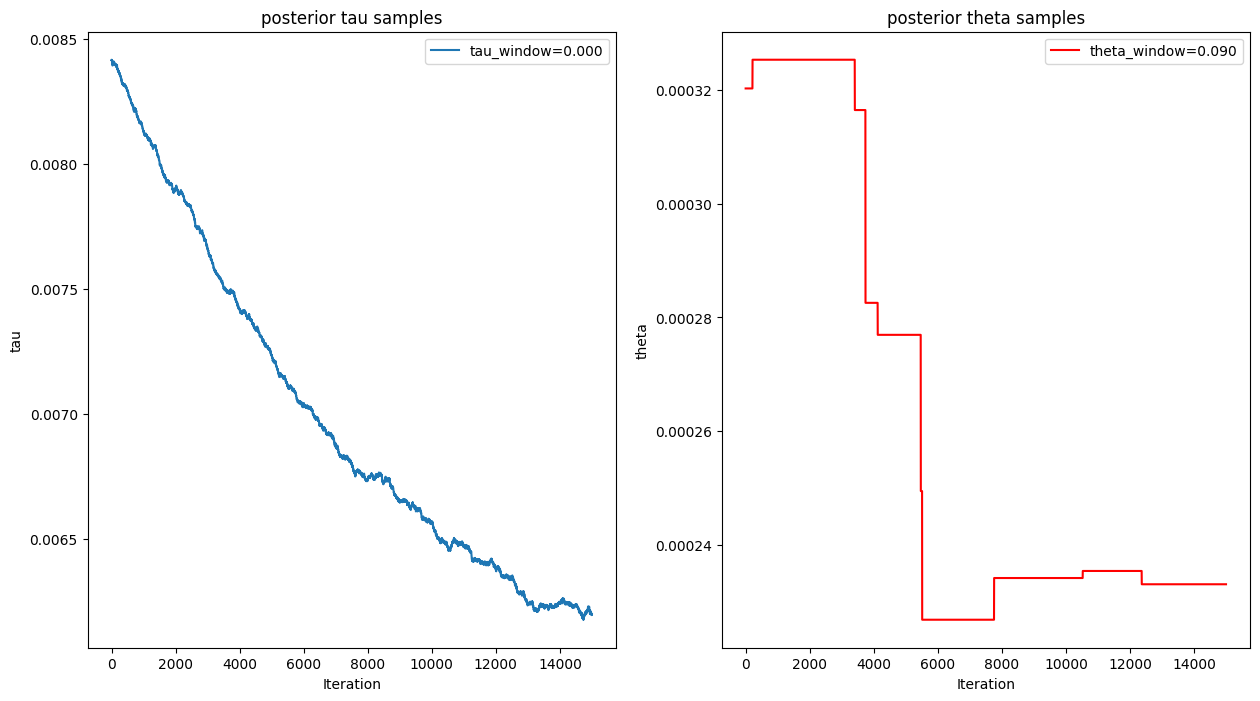

For tau, we obtain a posterior mean of 0.006993 
with 2.5% and 97.5% cred. interval [0.006215, 0.008317]
For theta, we obtain a posterior mean of 0.000261 
with 2.5% and 97.5% cred. interval [0.000227, 0.000325]


tau window: 0.001, theta window: 0.000
Summary for tau samples
             0
mean  0.004835
std   0.000224
Acceptance: 0.4367
Efficiency: 0.06579850291019652

Summary for theta samples
             0
mean  0.002111
std   0.000389
Acceptance: 0.9675
Efficiency: 0.05886139354014492



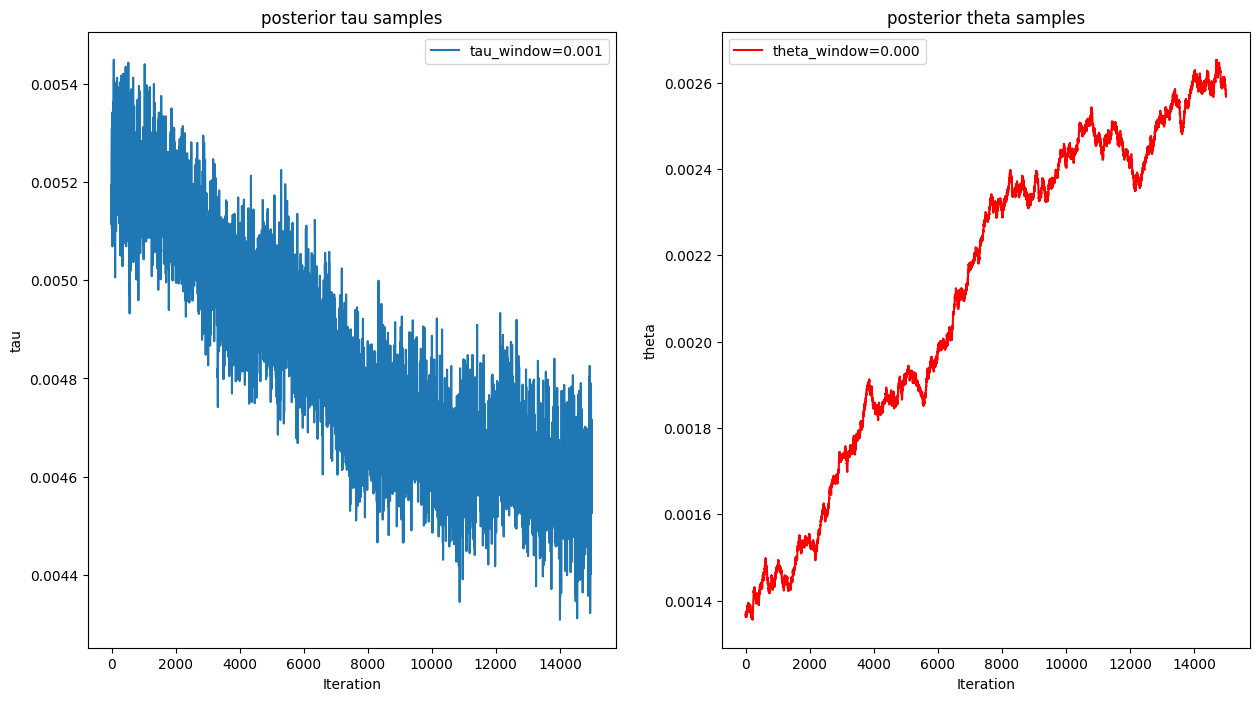

For tau, we obtain a posterior mean of 0.004835 
with 2.5% and 97.5% cred. interval [0.004494, 0.005270]
For theta, we obtain a posterior mean of 0.002111 
with 2.5% and 97.5% cred. interval [0.001415, 0.002608]


tau window: 0.001, theta window: 0.001
Summary for tau samples
             0
mean  0.004012
std   0.000143
Acceptance: 0.4324
Efficiency: 0.0841561916776256

Summary for theta samples
             0
mean  0.003984
std   0.000304
Acceptance: 0.4315
Efficiency: 0.07463012570528774



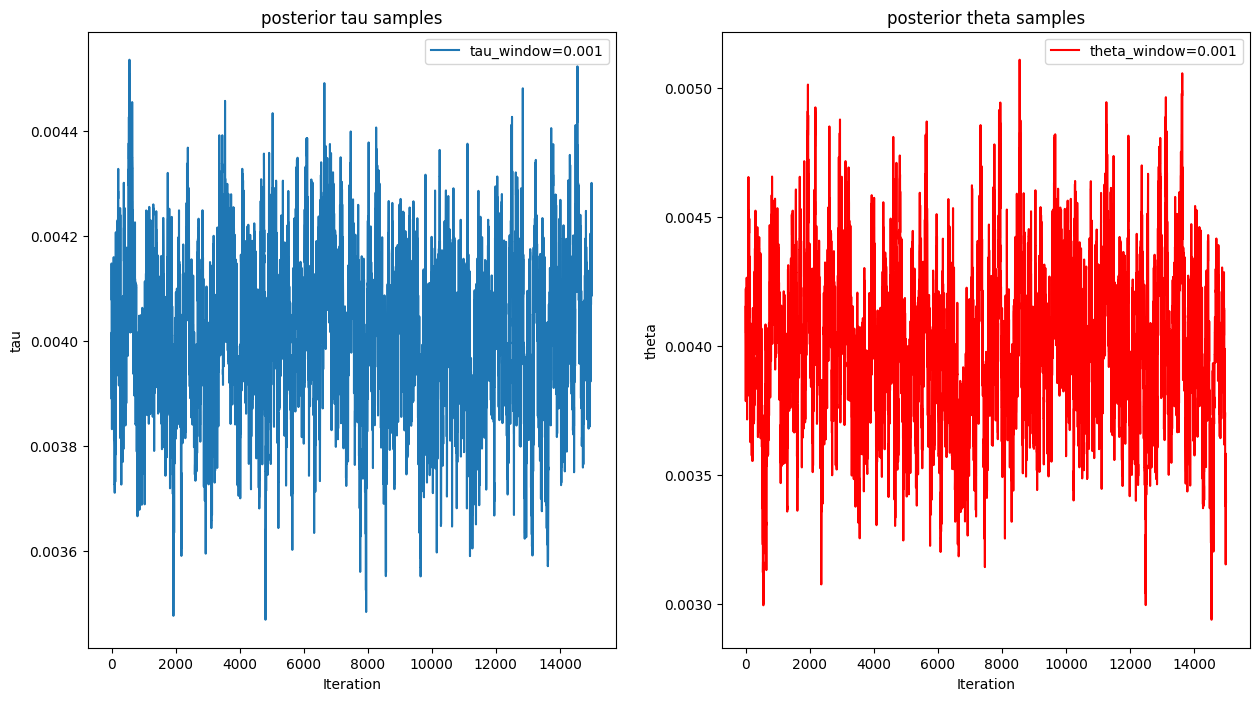

For tau, we obtain a posterior mean of 0.004012 
with 2.5% and 97.5% cred. interval [0.003728, 0.004294]
For theta, we obtain a posterior mean of 0.003984 
with 2.5% and 97.5% cred. interval [0.003416, 0.004609]


tau window: 0.001, theta window: 0.090
Summary for tau samples
             0
mean  0.004033
std   0.000157
Acceptance: 0.4299
Efficiency: 0.0769194812114287

Summary for theta samples
             0
mean  0.003927
std   0.000346
Acceptance: 0.0064
Efficiency: 0.05932399220000911



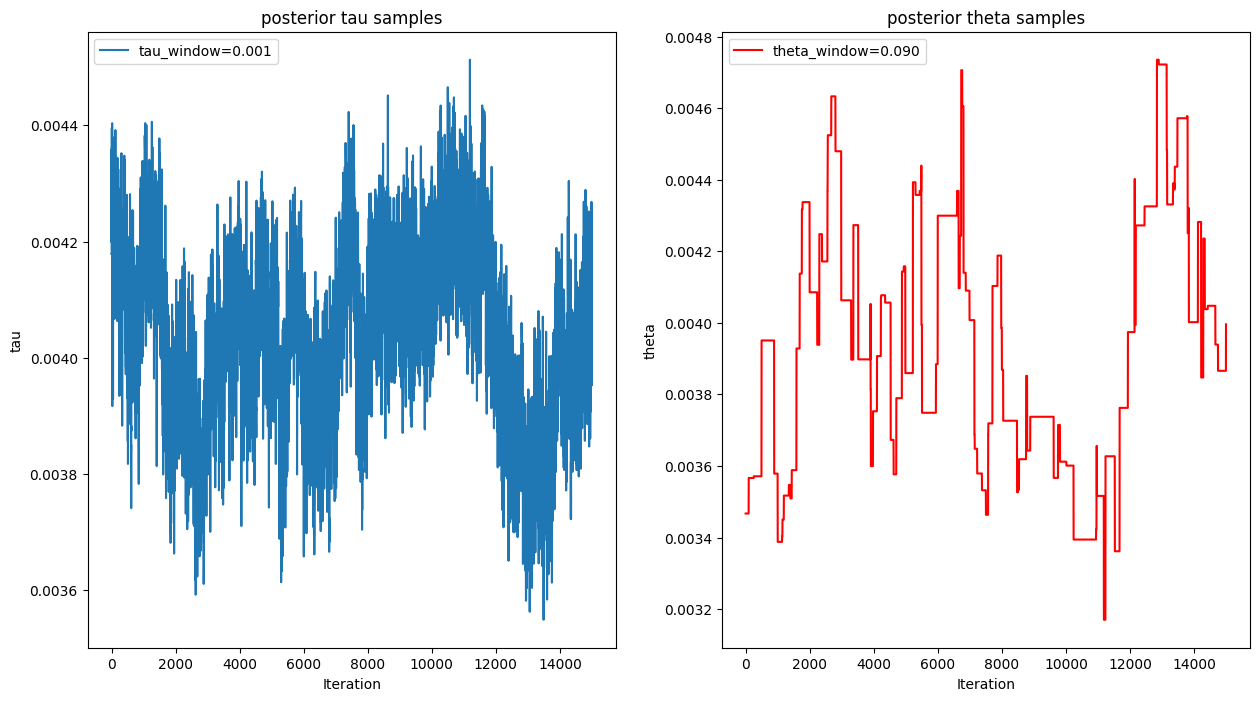

For tau, we obtain a posterior mean of 0.004033 
with 2.5% and 97.5% cred. interval [0.003726, 0.004322]
For theta, we obtain a posterior mean of 0.003927 
with 2.5% and 97.5% cred. interval [0.003394, 0.004633]


tau window: 0.053, theta window: 0.000
Summary for tau samples
             0
mean  0.004863
std   0.000157
Acceptance: 0.00905
Efficiency: 0.05970240927394393

Summary for theta samples
             0
mean  0.002027
std   0.000245
Acceptance: 0.9639
Efficiency: 0.05888109300227063



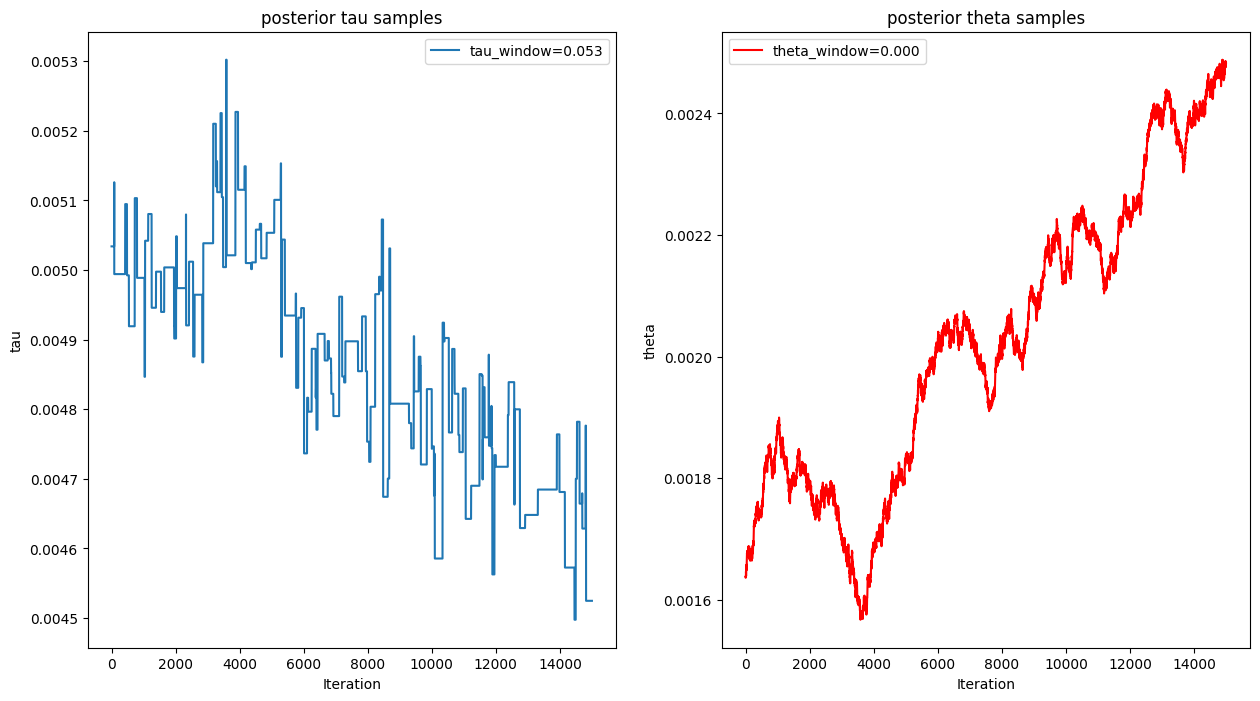

For tau, we obtain a posterior mean of 0.004863 
with 2.5% and 97.5% cred. interval [0.004573, 0.005115]
For theta, we obtain a posterior mean of 0.002027 
with 2.5% and 97.5% cred. interval [0.001625, 0.002453]


tau window: 0.053, theta window: 0.001
Summary for tau samples
             0
mean  0.004024
std   0.000176
Acceptance: 0.0103
Efficiency: 0.05946058499030534

Summary for theta samples
             0
mean  0.003972
std   0.000341
Acceptance: 0.4304
Efficiency: 0.0704393101084235



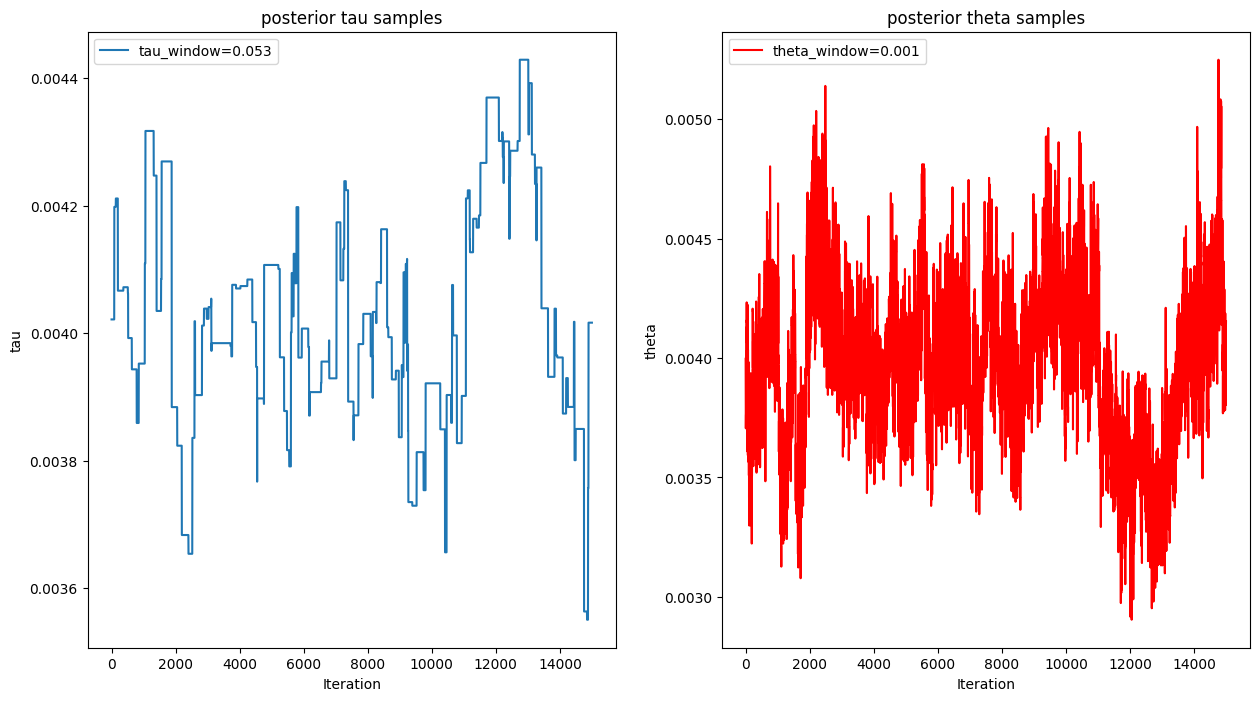

For tau, we obtain a posterior mean of 0.004024 
with 2.5% and 97.5% cred. interval [0.003684, 0.004370]
For theta, we obtain a posterior mean of 0.003972 
with 2.5% and 97.5% cred. interval [0.003287, 0.004624]


tau window: 0.053, theta window: 0.090
Summary for tau samples
             0
mean  0.004017
std   0.000123
Acceptance: 0.0096
Efficiency: 0.06034662040947245

Summary for theta samples
             0
mean  0.004028
std   0.000293
Acceptance: 0.00915
Efficiency: 0.059414502641035837



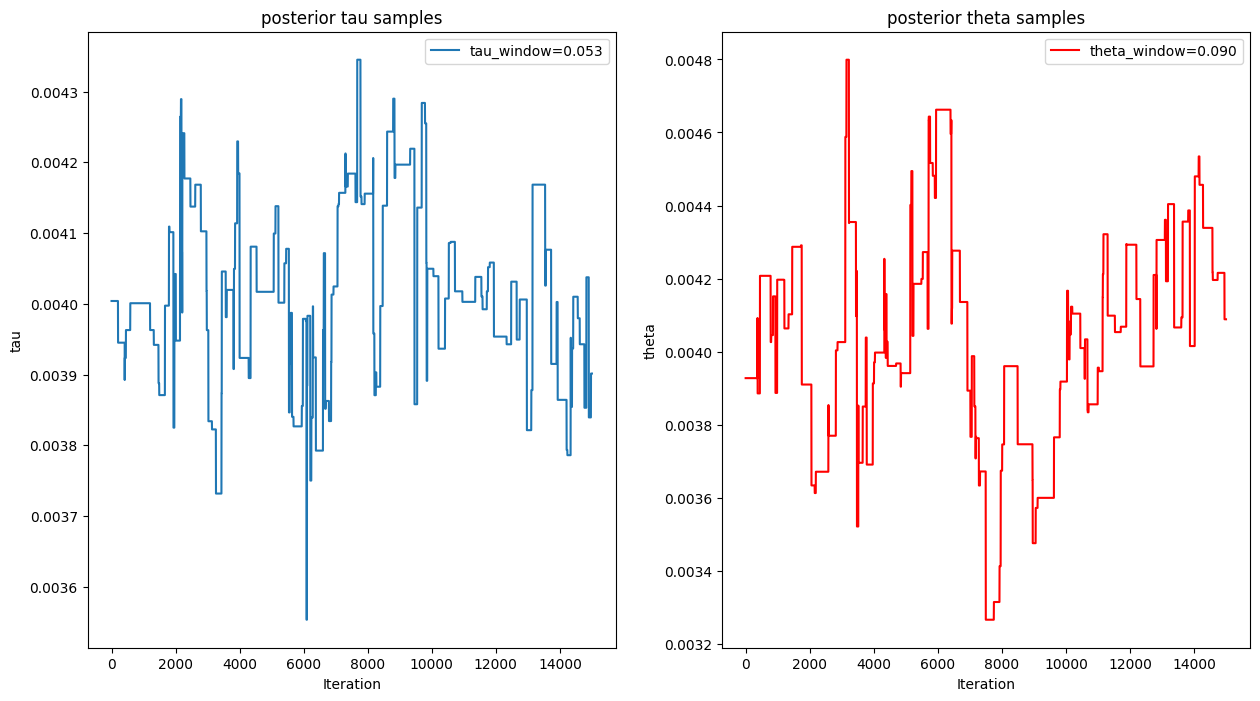

For tau, we obtain a posterior mean of 0.004017 
with 2.5% and 97.5% cred. interval [0.003793, 0.004243]
For theta, we obtain a posterior mean of 0.004028 
with 2.5% and 97.5% cred. interval [0.003314, 0.004662]




In [62]:

# Experiments to exploring varying windows sizes
w_tau = 0.00053
w_theta =  0.0009 
w_t = 0.019
tau_windows = np.logspace(np.log10(w_tau)-2, np.log10(w_tau)+2, 3)
theta_windows = np.logspace(np.log10(w_theta)-2, np.log10(w_theta)+2, 3)

def run_mcmc(tau, theta, tau_window, theta_window):
    tau = tau
    theta = theta
    coalescent_times = np.array([0.001 for _ in range(df.shape[0])])  # 1000 coalescent times
    init_windows = (tau_window, theta_window, w_t)
    init_params = (tau, theta, coalescent_times)
    results = mcmc(steps=SAMPLES, init_windows=init_windows, init_params=init_params)
    return results

results_list = []
for tau_window in tau_windows:
    for theta_window in theta_windows:
        results = run_mcmc(tau, theta, tau_window, theta_window)
        results_list.append(results) # record results for later use
        sample_tau, sample_theta, _, accepted_tau, accepted_theta, _ = results
        sample_tau_burned = sample_tau[BURNIN:]
        sample_theta_burned = sample_theta[BURNIN:]
        print(f"tau window: {tau_window:.3f}, theta window: {theta_window:.3f}")
        print(f"Summary for tau samples")
        print(pd.DataFrame(sample_tau_burned).describe().loc[['mean', 'std']])
        eff = 1/(1+2*sum(acf(sample_tau_burned)))
        print("Acceptance: {}".format(accepted_tau/SAMPLES))
        print("Efficiency: {}\n".format(eff))

        # show summary statistics for the runs discarding the first BURNIN samples
        print(f"Summary for theta samples")
        print(pd.DataFrame(sample_theta_burned).describe().loc[['mean', 'std']])
        eff = 1/(1+2*sum(acf(sample_theta_burned)))
        print("Acceptance: {}".format(accepted_theta/SAMPLES))
        print("Efficiency: {}\n".format(eff))
        # Plotting trace plots
        fig, ax = plt.subplots(1, 2, figsize=(15, 8))

        ax[0].plot(list(range(len(sample_tau_burned))),sample_tau_burned,label=f"tau_window={tau_window:.3f}")
        ax[0].set_title('posterior tau samples')
        ax[0].set_xlabel('Iteration')
        ax[0].set_ylabel('tau')
        ax[0].legend()

        ax[1].plot(list(range(len(sample_theta_burned))),sample_theta_burned,label=f"theta_window={theta_window:.3f}", color='r')
        ax[1].set_title('posterior theta samples')
        ax[1].set_xlabel('Iteration')
        ax[1].set_ylabel('theta')
        ax[1].legend()

        plt.show()
        print(f'For tau, we obtain a posterior mean of {np.mean(sample_tau_burned):.6f} \nwith 2.5% and 97.5% cred. interval [{np.quantile(sample_tau_burned, 0.025):.6f}, {np.quantile(sample_tau_burned, 0.975):.6f}]')
        print(f'For theta, we obtain a posterior mean of {np.mean(sample_theta_burned):.6f} \nwith 2.5% and 97.5% cred. interval [{np.quantile(sample_theta_burned, 0.025):.6f}, {np.quantile(sample_theta_burned, 0.975):.6f}]')
        
        
        print('\n')

# You can then analyze the results and plot the running time, acceptance rate, and efficiency for each combination of tau and theta window sizes.


In [65]:
print((tau_windows, theta_windows))

(array([5.3e-06, 5.3e-04, 5.3e-02]), array([9.e-06, 9.e-04, 9.e-02]))
